In [1]:
import random
import numpy as np
import itertools
from Bio import SeqIO
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

print('libraries loaded!')

libraries loaded!


In [92]:
# This function mutates num_mutations number of mutations to a diferent nucleotide in a given sequence

def mutate_dna(dna_string, num_mutations):
    dna_list = list(dna_string)
    dna_length = len(dna_list)
    num_mutations = int(num_mutations * dna_length)
    if num_mutations > dna_length:
        raise ValueError("Number of mutations cannot exceed the length of the DNA string.")

    mutation_indices = random.sample(range(dna_length), num_mutations)

    for index in mutation_indices:
        current_base = dna_list[index]
        valid_bases = ['A', 'U', 'C', 'G']
        if current_base not in valid_bases:
            continue
        else:
            valid_bases.remove(current_base) # Ensure the new base is different.
            new_base = random.choice(valid_bases)
            dna_list[index] = new_base

    return "".join(dna_list)  # Convert back to a string

In [6]:
f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict_2.fasta'

In [93]:
from tqdm import tqdm
klen = 4
kmers = {}
total_seqs = 0

for h,i in tqdm(enumerate(SeqIO.parse(f,'fasta'))):
    id,d,s,L = str(i.id),str(i.description),str(i.seq).upper(),len(i.seq)
    total_seqs += 1
    for i in range(0,len(s)+1-klen*2):
        kmer = s[i:i+klen]
        next_mer = s[i+klen:i+klen*2]
        if kmer not in kmers: kmers[kmer] = defaultdict(int)
        kmers[kmer][next_mer] += 1
    if h == 100000: break

print("Run finished!")

91281it [02:00, 755.07it/s]

Run finished!


In [94]:
total_kmer_count = sum(sum(v.values()) for v in kmers.values())
total_kmer_count

137361054

In [120]:
bio_neighbor_mers = {}
n_marker = 0

for kmer,v in kmers.items():
    # print(kmer)
    total_nextmer_count = sum(v.values())
    for next_mer,counts in v.items():
        proportion = counts/total_nextmer_count
        if proportion >= 0.2:
            if kmer not in bio_neighbor_mers:
                bio_neighbor_mers[kmer] = set()
            bio_neighbor_mers[kmer].add(next_mer)
            n_marker += 1
            # print(kmer,next_mer,proportion)

print(f"k-mer filtering step complete! Found {n_marker} biomarkers!")

k-mer filtering step complete! Found 40 biomarkers!


In [116]:
print(len(bio_neighbor_mers))
print(bio_neighbor_mers)

2
{'GUUC': {'CCGG'}, 'ACAU': {'GCAA'}}


In [113]:
def get_biomarker_stats(seq):
    biomarkers_present = {}
    mer_nextMer_present = 0
    
    for i in range(0,len(s)+1-klen*2):
        kmer = seq[i:i+klen]
        next_mer = seq[i+klen:i+klen*2]
        if kmer in bio_neighbor_mers:
            if next_mer in bio_neighbor_mers[kmer]:
                if kmer not in biomarkers_present:
                    biomarkers_present[kmer] = defaultdict(int)
                mer_nextMer_present += 1
                biomarkers_present[kmer][next_mer] += 1
    return biomarkers_present, mer_nextMer_present

In [150]:
real,mutated = [],[]

total = 0
for h,i in enumerate(SeqIO.parse(f,'fasta')):
    total = h
    id,d,s,L = str(i.id),str(i.description),str(i.seq).upper(),len(i.seq)
    mutated_seq = mutate_dna(s, 0.05)
    biomarker_stats_real,biomarker_stats_real_total = get_biomarker_stats(s)
    biomarker_stats_mutated,biomarker_stats_mutated_total = get_biomarker_stats(mutated_seq)
    real.append(biomarker_stats_real_total)
    mutated.append(biomarker_stats_mutated_total)
    # print(biomarker_stats_real_total,biomarker_stats_mutated_total)
    print(h,end='\r')
    if h == 1000: break

/tmp/ipykernel_2182693/2336531353.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([real,mutated],labels = ["Real","Mutated"])


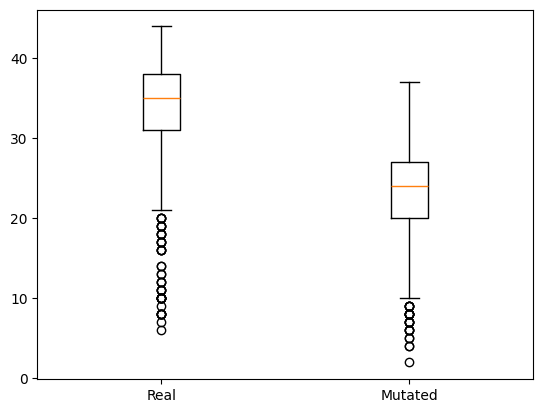

In [151]:
plt.boxplot([real,mutated],labels = ["Real","Mutated"])
plt.show()

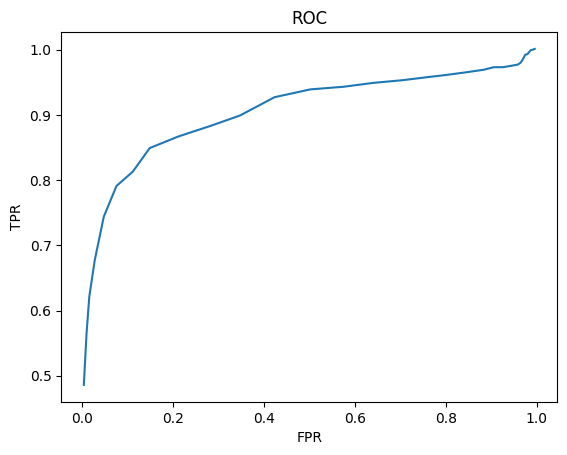

In [152]:
# thresholding ROC curve
max_thresh = np.max(mutated)
min_thresh = np.min(real)

TPRs = []
FPRs = []
for thresh in range(min_thresh,max_thresh):
    TPs = np.sum(np.array(real) >= thresh)
    FPs = np.sum(np.array(mutated) >= thresh)
    TPRs.append(TPs/total)
    FPRs.append(FPs/total)

plt.plot(FPRs, TPRs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()